# Augmentation

## Import Package


In [1]:
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [3]:
SEED = 5397
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # Show GPU information
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

Not connected to a TPU runtime. Using CPU/GPU strategy
Found GPU at: /device:GPU:0
Sun Oct 23 08:02:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W /  70W |    312MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
     

## Const & Inputs

Here are all of the parameters to change for the run.


In [7]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = ".."
# path = "/content/drive/MyDrive/Colab Notebooks/aidea-farmland-crops-autumn"

# Folder of the training data
training_folder = 'D:/Dataset/aidea-farmland-crops-autumn/train'

# Folder of the public data
public_folder = 'D:/Dataset/aidea-farmland-crops-autumn/public'

# Number of classes in the dataset
num_classes = 33

# Image size for model
image_size = 224

# options: (subset, fullset)
train_mode = 'subset'

# Get the shape of the input layer
input_shape = (image_size, image_size, 3)

In [5]:
tw = ["非作物", "甘藍", "甘藷", "檳榔", "芒果", "竹筍", "茶", "蔥", "木瓜", "太陽麻", "紅豆", "毛豆", "芋", "葡萄", "青花菜", "茭白筍", "絲瓜",
      "荔枝", "龍眼", "韭菜", "狼尾草", "檸檬", "萵苣", "花椰菜", "梨", "田菁", "番荔枝", "百香果", "蓮霧", "結球白菜", "溫網室", "洋蔥", "蘆筍"]
en = ["others", "kale", "sweetpotato", "betel", "mango", "bambooshoots", "tea", "greenonion", "papaya", "sunhemp", "redbeans", "soybeans", "taro", "grape", "broccoli", "waterbamboo", "loofah", "litchi",
      "longan", "chinesechives", "pennisetum", "lemon", "lettuce", "cauliflower", "pear", "sesbania", "custardapple", "passionfruit", "roseapple", "chinesecabbage", "greenhouse", "onion", "asparagus"]
classes_name = pd.DataFrame({"tw": tw, "en": en}).sort_values(by=['en'], ignore_index=True)

## Data Preprocessing

Include: laod data, encode categorical features, split data, normalize data, and save data.


### Load Data
The training set has been randomly split into train (85%) and valid (15%) in advance.

In [8]:
data = pd.read_pickle(F'{path}/data/{train_mode}.pkl')
train = pd.read_pickle(F'{path}/data/{train_mode}_train_vector_{image_size}.pkl')
valid = pd.read_pickle(F'{path}/data/{train_mode}_valid_vector_{image_size}.pkl')

### Encode categorical features

OneHotEncoder


In [9]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(data['label'].values.reshape(-1, 1))
train['class'] = list(np.array(enc.transform(train['label'].values.reshape(-1, 1)).toarray().tolist()))
valid['class'] = list(np.array(enc.transform(valid['label'].values.reshape(-1, 1)).toarray().tolist()))

### Prepare Data
We only need vector and class for training.

In [11]:
def get_batch_dataset(train_vector, train_class, valid_vector, valid_class, batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices((train_vector, train_class)).shuffle(5000, seed=5397).batch(batch_size, drop_remainder=True)
    valid_ds = tf.data.Dataset.from_tensor_slices((valid_vector, valid_class)).batch(batch_size, drop_remainder=True)
    return train_ds, valid_ds

In [10]:
train_vector, train_class = np.array(train['vector'].tolist()), np.array(train['class'].tolist()) 
valid_vector, valid_class = np.array(valid['vector'].tolist()), np.array(valid['class'].tolist()) 

In [13]:
train_ds, valid_ds = get_batch_dataset(train_vector, train_class, valid_vector, valid_class, 16)

## Data Augmentation
使用 tensorflow 的 augmentation layer 進行影像增強，但用於訓練模型後績效未提升  

推測因為原始影像大多僅往 -90 (+270) 度傾斜，使得 `RandomRotation` 與 `RandomFlip` 相對之下產生過多無用樣本

In [12]:
def get_augmentation():
    augmentation = tf.keras.models.Sequential()
    # augmentation.add(tf.keras.layers.RandomContrast(factor=0.15))
    augmentation.add(tf.keras.layers.RandomFlip('horizontal_and_vertical'))
    # augmentation.add(tf.keras.layers.RandomZoom(0.15, 0.15))
    augmentation.add(tf.keras.layers.RandomTranslation(height_factor=0.15, width_factor=0.15))
    augmentation.add(tf.keras.layers.RandomRotation(factor=0.15))
    return augmentation

### Data Augmentation Visualize 

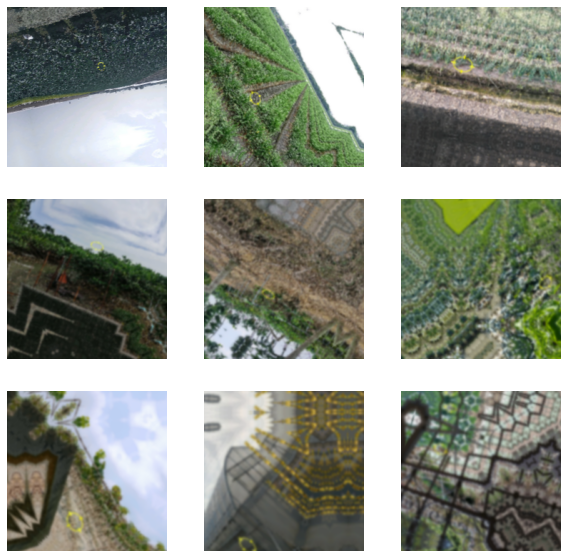

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmentation = get_augmentation()
    images = augmentation(images)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

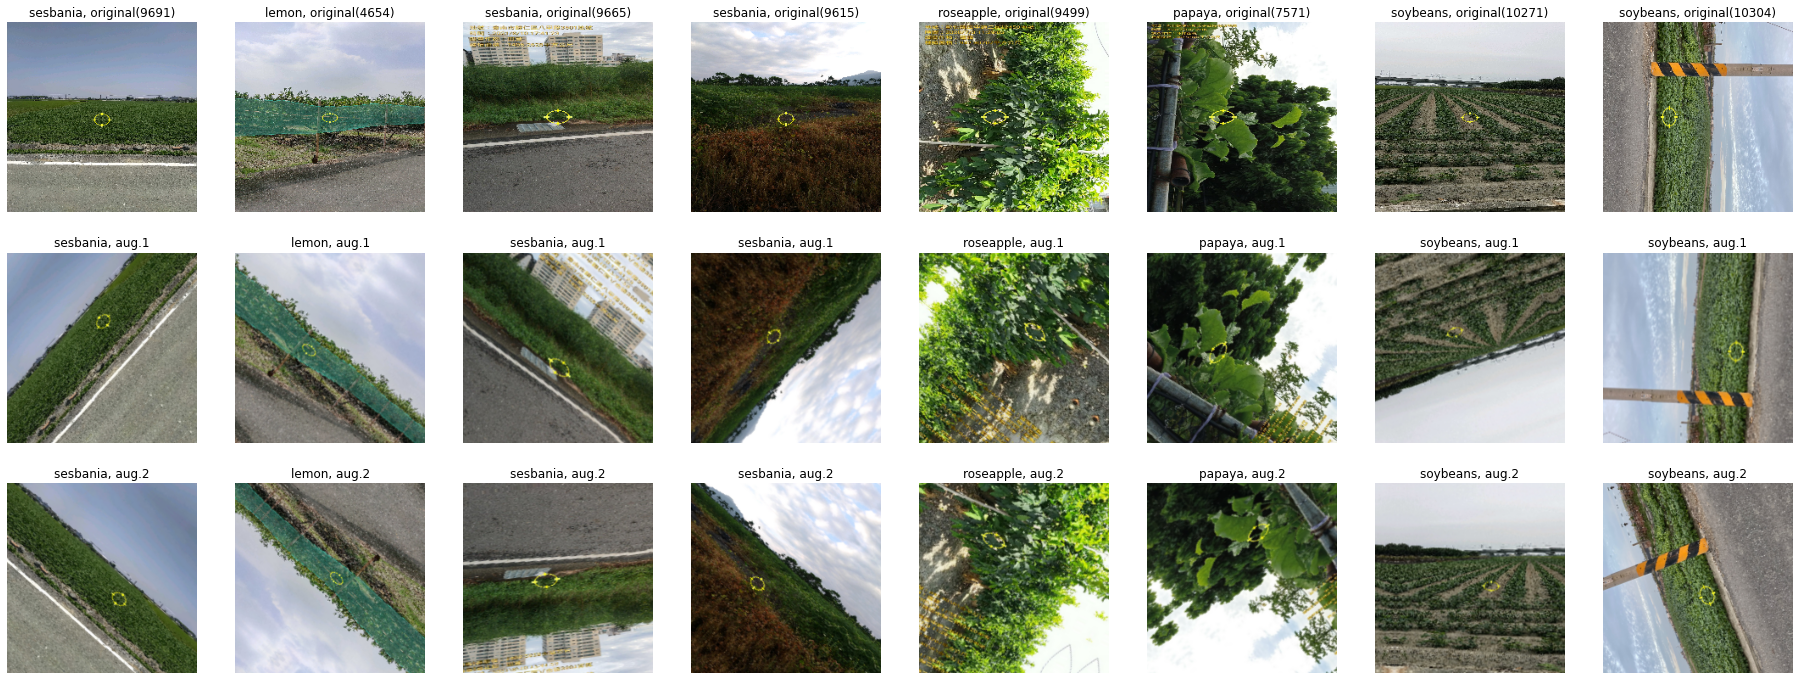

In [15]:
def row_based_idx(num_rows, num_cols, idx):
    return np.arange(1, num_rows*num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx-1]

items = 8
variants = 2
augmentation = get_augmentation()
plt.figure(figsize=(items * 4, variants * 6))
for item in range(items):
    idx = random.randint(0, len(train_vector))
    image, label = train_vector[idx], train_class[idx]
    ax = plt.subplot((variants + 1), items, row_based_idx((variants + 1), items, item * (variants + 1) + 1))
    # original
    plt.imshow(image.astype("uint8"))
    plt.title("{}, original({})".format(classes_name['en'][np.argmax(label)], idx))
    plt.axis("off")
    # aug_img_1
    ax = plt.subplot((variants + 1), items, row_based_idx((variants + 1), items, item * (variants + 1) + 2))
    aug_img_1 = augmentation(image)
    plt.imshow(aug_img_1.numpy().astype("uint8"))
    plt.title("{}, aug.{}".format(classes_name['en'][np.argmax(label)], 1))
    plt.axis("off")
    # aug_img_2
    ax = plt.subplot((variants + 1), items, row_based_idx((variants + 1), items, item * (variants + 1) + 3))
    aug_img_2 = augmentation(image)
    plt.imshow(aug_img_2.numpy().astype("uint8"))
    plt.title("{}, aug.{}".format(classes_name['en'][np.argmax(label)], 2))
    plt.axis("off")